In [195]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from meteostat import Point, Hourly
from datetime import datetime
from pandas.api.types import CategoricalDtype

#set notebook options
pd.options.mode.chained_assignment = None 
pd.set_option('display.max_columns', None)
plt.rcParams.update({'font.size': 10})
sns.set_style("white")
plt_color = 'cadetblue'

# Let's take a look at the Collisions/crashes dataframe

Data downloaded from: https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95 

In [186]:
# import data from data folder
df = pd.read_csv('./Data/Motor_Vehicle_Collisions_Crashes.csv')

In [277]:
df['HOUR'] = pd.to_datetime(df['CRASH TIME'], format='%H:%M').dt.hour
df['MINUTE'] = pd.to_datetime(df['CRASH TIME'], format='%H:%M').dt.minute
df['CRASH DATE'] = pd.to_datetime(df['CRASH DATE'])
df['YEAR'] = df['CRASH DATE'].dt.year
df['MONTH'] = df['CRASH DATE'].dt.month
df['DAY'] = df['CRASH DATE'].dt.day
df['WEEKDAY'] = df['CRASH DATE'].dt.day_name()
dayorder = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['WEEKDAY'] = df['WEEKDAY'].astype(CategoricalDtype(categories=dayorder, ordered=True))
df['HOUR OF WEEK'] = df['CRASH DATE'].dt.dayofweek * 24 + (df.HOUR + 1).astype(int)
# drop data from 2023
df = df[(df.YEAR > 2012) & (df.YEAR < 2023)]

#sort data on CRASH DATE
df = df.sort_values(by=['CRASH DATE']).reset_index(drop=True)

# keep data from 2017-2022
#df = df[(df['YEAR'] >= 2017) & (df['YEAR'] <= 2022)]

In [278]:
df.head()

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5,HOUR,MINUTE,YEAR,MONTH,DAY,WEEKDAY,SEVERITY,HOUR OF WEEK
0,2013-01-01,5:00,QUEENS,11372,40.750916,-73.873161,"(40.7509158, -73.8731615)",94 STREET,37 AVENUE,NaN,0.0,0.0,0,0,0,0,0,0,Driver Inattention/Distraction,Unspecified,Unspecified,NaN,NaN,281033,PASSENGER VEHICLE,SPORT UTILITY / STATION WAGON,SPORT UTILITY / STATION WAGON,NaN,NaN,5,0,2013,1,1,Tuesday,NON-SEVERE,30
1,2013-01-01,21:30,STATEN ISLAND,10305,40.602735,-74.083335,"(40.6027349, -74.0833353)",SHERIDAN AVENUE,CRIST STREET,NaN,0.0,0.0,0,0,0,0,0,0,Tire Failure/Inadequate,Unspecified,Unspecified,NaN,NaN,295926,PASSENGER VEHICLE,PASSENGER VEHICLE,PASSENGER VEHICLE,NaN,NaN,21,30,2013,1,1,Tuesday,NON-SEVERE,46
2,2013-01-01,17:48,BROOKLYN,11208,40.680222,-73.871201,"(40.6802223, -73.8712013)",WELDON STREET,CRESCENT STREET,NaN,0.0,0.0,0,0,0,0,0,0,Unspecified,Unspecified,NaN,NaN,NaN,165524,PASSENGER VEHICLE,UNKNOWN,NaN,NaN,NaN,17,48,2013,1,1,Tuesday,NON-SEVERE,42
3,2013-01-01,2:50,MANHATTAN,10013,40.726436,-74.005657,"(40.7264365, -74.0056572)",VARICK STREET,VANDAM STREET,NaN,0.0,0.0,0,0,0,0,0,0,Passenger Distraction,Unspecified,NaN,NaN,NaN,1580,PASSENGER VEHICLE,SPORT UTILITY / STATION WAGON,NaN,NaN,NaN,2,50,2013,1,1,Tuesday,NON-SEVERE,27
4,2013-01-01,15:30,QUEENS,11358,40.767764,-73.789317,"(40.7677638, -73.7893167)",33 AVENUE,JORDAN STREET,NaN,1.0,0.0,0,0,0,0,1,0,Unspecified,NaN,NaN,NaN,NaN,260764,MOTORCYCLE,NaN,NaN,NaN,NaN,15,30,2013,1,1,Tuesday,SEVERE,40


In [189]:
df.loc[df['NUMBER OF PERSONS KILLED'] >= 1, 'SEVERITY'] = 'FATAL'
df.loc[(df['NUMBER OF PERSONS INJURED'] >= 1)  & (df['NUMBER OF PERSONS KILLED'] == 0), 'SEVERITY'] = 'SEVERE'
df.loc[(df['NUMBER OF PERSONS INJURED'] == 0)  & (df['NUMBER OF PERSONS KILLED'] == 0), 'SEVERITY'] = 'NON-SEVERE'
# df['FATAL'] = (df['NUMBER OF PERSONS KILLED'] >= 1).astype(int)
# df['SEVERE'] = ((df['NUMBER OF PERSONS INJURED'] >= 1)  & (df['NUMBER OF PERSONS KILLED'] == 0)).astype(int)
# df['NON-SEVERE'] = ((df['NUMBER OF PERSONS INJURED'] == 0)  & (df['NUMBER OF PERSONS KILLED'] == 0)).astype(int).astype(int)
# df.FATAL.sum()

In [190]:
# number of missing location values every year
df.groupby('YEAR')['BOROUGH','LATITUDE', 'LONGITUDE'].apply(lambda x: x.isnull().sum())


,BOROUGH,LATITUDE,LONGITUDE
YEAR,,,
2013,47761,31800,31800
2014,49685,33295,33295
2015,54231,34714,34714
2016,76527,37215,37215
2017,88053,13923,13923
2018,82330,15118,15118
2019,74462,17372,17372
2020,39228,8917,8917
2021,38332,8786,8786


In [191]:
# calculate the proportion of missing values per year
df.groupby('YEAR')['BOROUGH','LATITUDE', 'LONGITUDE'].apply(lambda x: x.isnull().sum()/len(x))

,BOROUGH,LATITUDE,LONGITUDE
YEAR,,,
2013,0.234428,0.156086,0.156086
2014,0.241151,0.161600,0.161600
2015,0.249116,0.159462,0.159462
2016,0.332971,0.161923,0.161923
2017,0.381170,0.060271,0.060271
2018,0.355539,0.065286,0.065286
2019,0.352090,0.082143,0.082143
2020,0.347409,0.078970,0.078970
2021,0.346752,0.079478,0.079478


In [192]:
# drop all rows where location is missing
df = df.dropna(subset=['LATITUDE', 'LONGITUDE'])


In [193]:
df.BOROUGH.value_counts()

BROOKLYN         394034
QUEENS           334466
MANHATTAN        275862
BRONX            182769
STATEN ISLAND     50260
Name: BOROUGH, dtype: int64

### Accidents By Time Frame

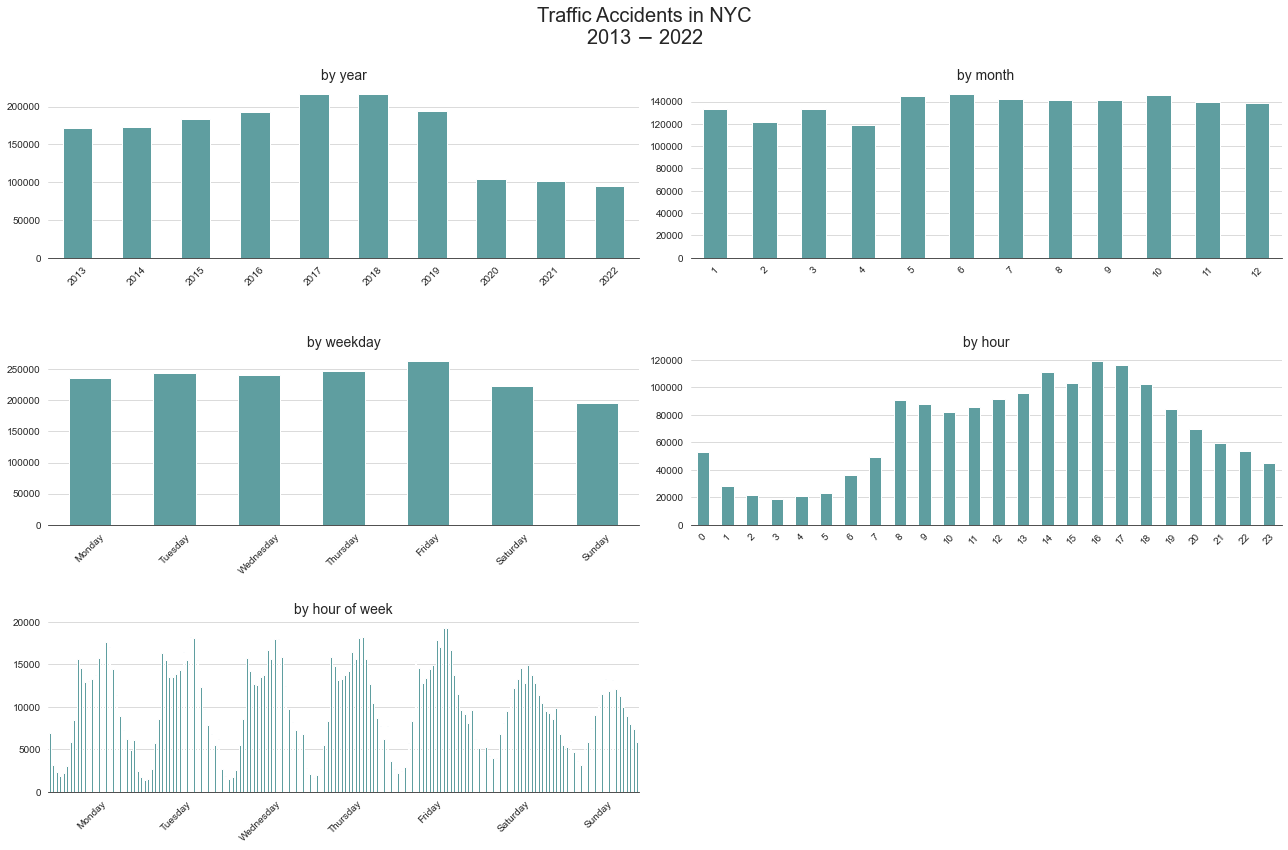

In [320]:
import matplotlib.ticker as ticker
fig, axes = plt.subplots(3,2)
timeframe = ['YEAR', 'MONTH', 'WEEKDAY', 'HOUR','HOUR OF WEEK']
for t, ax in zip(timeframe, axes.flatten()):
    df.groupby(t)['LOCATION'].size().plot.bar(rot=45, figsize=(18,12), color=plt_color, ax=ax)
    ax.set_title('\nby '+ t.lower(), fontsize=14)
    ax.set_xlabel('')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.yaxis.grid(True, color ="lightgrey")
    if t == 'HOUR OF WEEK':
        ax.xaxis.set_major_locator(ticker.FixedLocator((np.linspace(12, df['HOUR OF WEEK'].nunique()-12, 7))))
        ax.xaxis.set_major_formatter(ticker.FixedFormatter((dayorder)))
fig.delaxes(axes[2][1])
fig.suptitle('Traffic Accidents in NYC\n2013 $-$ 2022', fontsize=20)
plt.tight_layout()
plt.show()

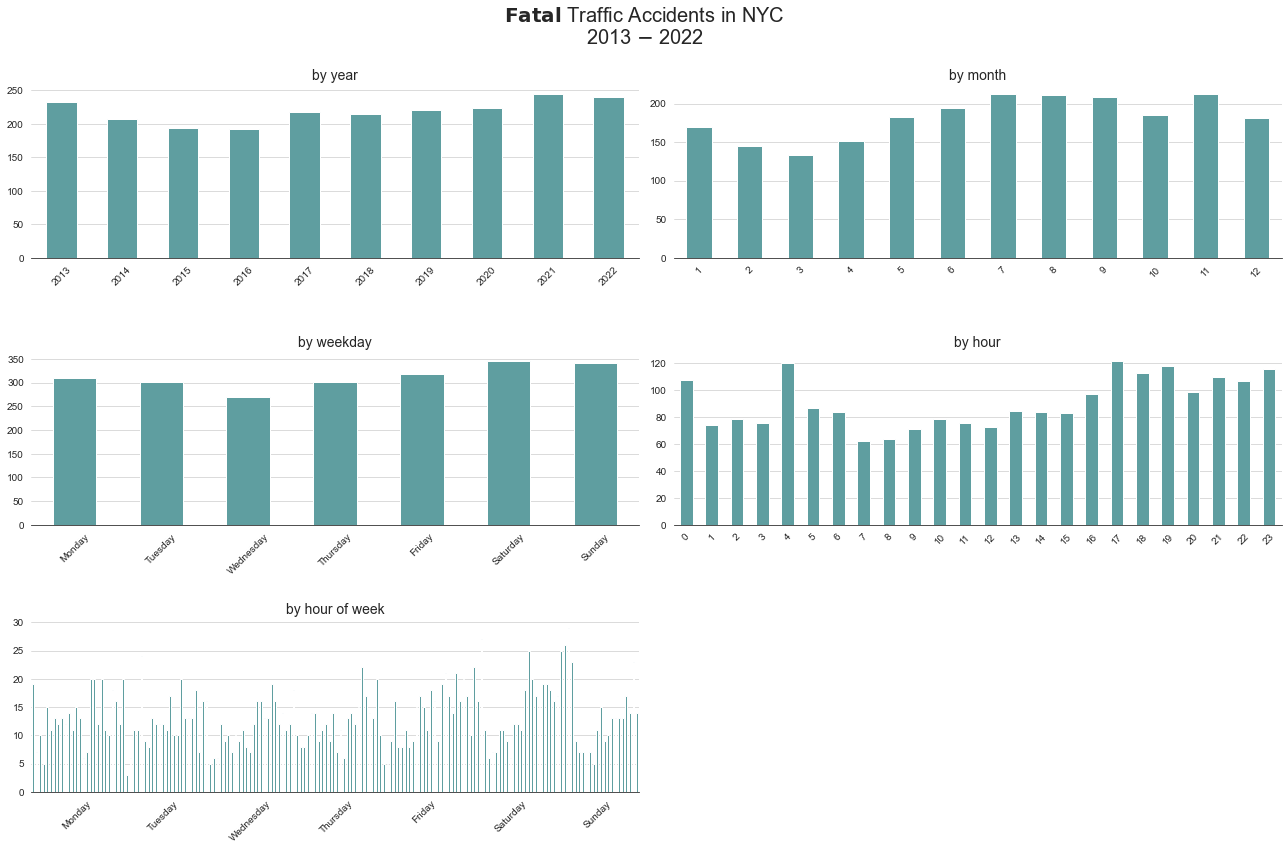

In [318]:
fig, axes = plt.subplots(3,2)
timeframe = ['YEAR', 'MONTH', 'WEEKDAY', 'HOUR','HOUR OF WEEK']
for t, ax in zip(timeframe, axes.flatten()):
    
    df[df.SEVERITY == 'FATAL'].groupby(t)['LOCATION'].size().plot.bar(rot=45, figsize=(18,12), color=plt_color, ax=ax)
    ax.set_title('\nby '+ t.lower(), fontsize=14)
    ax.set_xlabel('')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.yaxis.grid(True, color ="lightgrey")
    if t == 'HOUR OF WEEK':
        ax.xaxis.set_major_locator(ticker.FixedLocator((np.linspace(12, df['HOUR OF WEEK'].nunique()-12, 7))))
        ax.xaxis.set_major_formatter(ticker.FixedFormatter((dayorder)))
fig.delaxes(axes[2][1])
fig.suptitle(r'$\bf{Fatal}$ Traffic Accidents in NYC'+'\n2013 $-$ 2022', fontsize=20)
plt.tight_layout()
plt.show()

The total number of car accidents by hour is less during nights than during the day, however for *fatal* accidents the frequency does not follow the same behavior. For these types of accidents, the frequency does not drop during night with same effect as the total number of accidents. On the contrary, there is a significant peak of fatal accidents at 4 AM.

Number of Accidents is decreasing significantly in from 2019 to 2020 and onwards. This could be due to Covid-19 lockdown in March 2020. Let's see the number of accidents in 2020 by month.

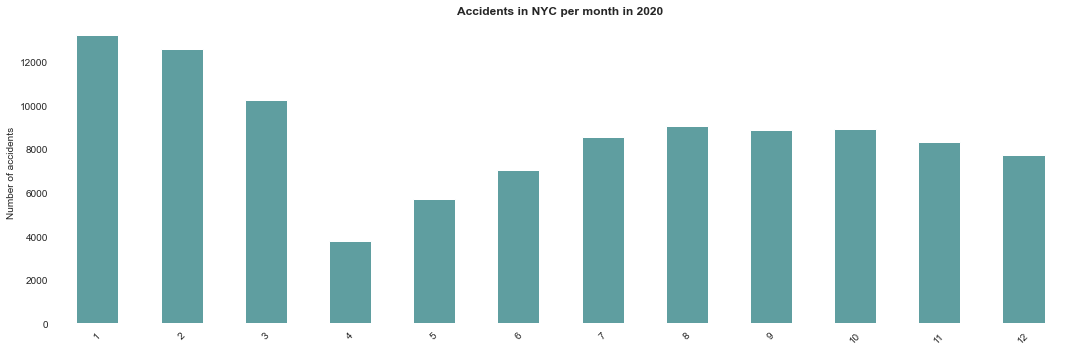

In [198]:
df[df.YEAR == 2020].groupby(['MONTH'])['LOCATION'].size().plot.bar(rot=45, figsize=(15,5), color=plt_color)
plt.title('Accidents in NYC per month in 2020', weight='bold')
plt.xlabel('')
plt.ylabel('Number of accidents')
plt.box(False)
plt.tight_layout()
plt.show()

### Accidents By Borough

In [355]:
ax

array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

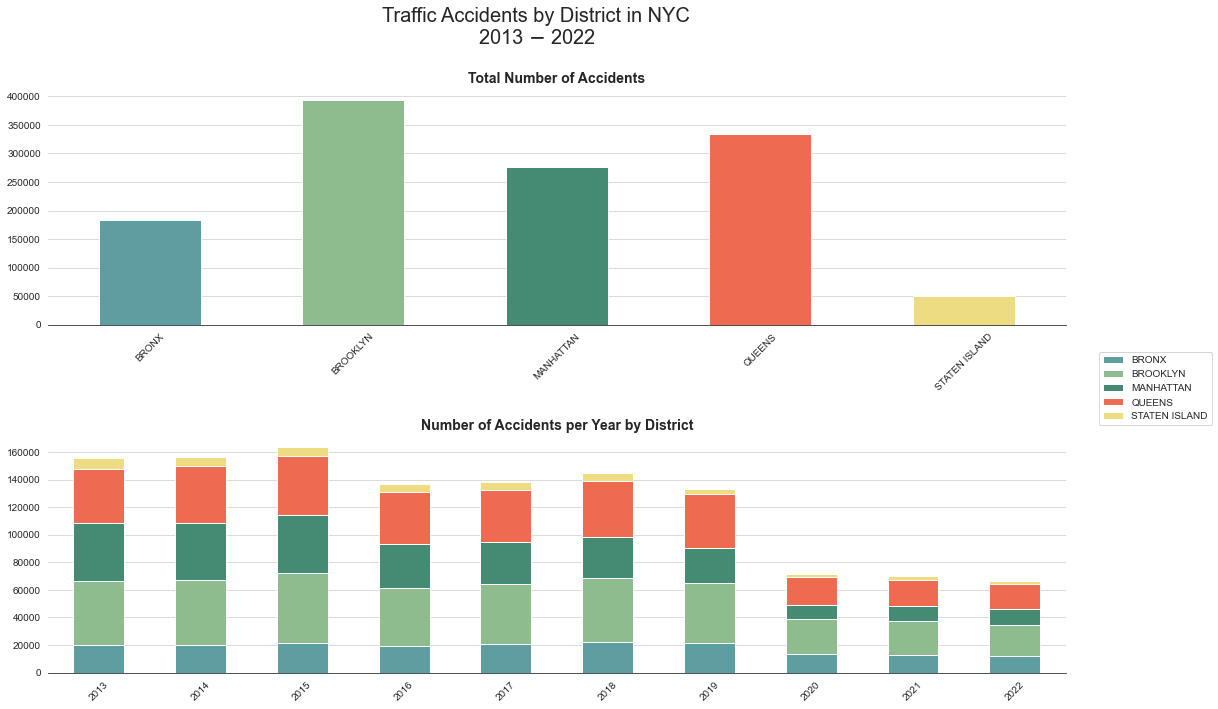

In [385]:
area_colors = [plt_color,'darkseagreen','#458B74','#EE6A50','#EEDC82']
fig, ax = plt.subplots(2,1)

df.groupby('BOROUGH').size().plot.bar(rot=45, color=area_colors, ax=ax[0], figsize=(15,10))
df.groupby(['YEAR','BOROUGH'])['LOCATION'].size().unstack(1).plot.bar(rot=45, color=area_colors, stacked=True, ax=ax[1],figsize=(15,10),)
for i in range(2):
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['left'].set_visible(False)
    ax[i].yaxis.grid(True, color ="lightgrey")
    ax[i].set_xlabel("")
    ax[i].legend().set_visible(False)
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(l, []) for l in zip(*lines_labels[1:])]
fig.legend(lines, labels, bbox_to_anchor = (1.13, 0.45), loc='center right')
ax[0].set_title('\nTotal Number of Accidents', weight='bold', fontsize=14)
ax[1].set_title('\nNumber of Accidents per Year by District', weight='bold', fontsize=14)
plt.suptitle('Traffic Accidents by District in NYC\n2013 $-$ 2022', fontsize=20)
plt.tight_layout()
plt.show()

In [405]:
type_freq = df.groupby('SEVERITY').size()*(1/1000)


array([   2.187, 1283.814,  362.479])

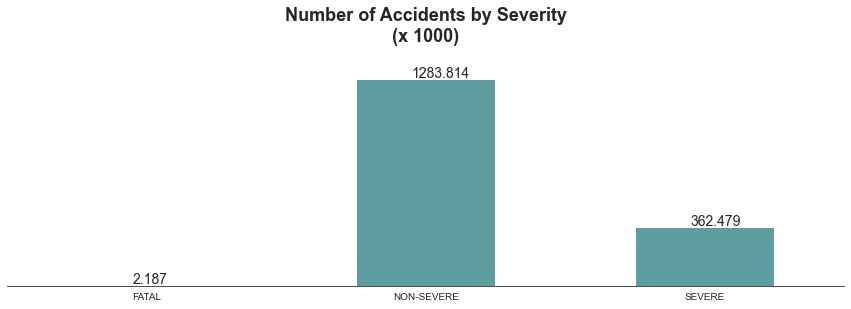

In [442]:
type_freq = df.groupby('SEVERITY').size()*(1/1000)

fig, ax = plt.subplots()    
type_freq.plot.bar(rot=0, color=plt_color, figsize=(15,4), ax=ax)
plt.title('Number of Accidents by Severity\n(x 1000)\n', weight='bold', fontsize=18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_yticks([])
ax.set_xlabel("")
for i, v in enumerate(list(type_freq.values)):
    ax.text(i-.05, v+10, str(v), fontsize=14)
#ax.set_ylabel('Count (x1000)')
plt.show()

In [184]:
# number of non-missing location values every year
df.groupby('YEAR')['BOROUGH','LATITUDE', 'LONGITUDE'].apply(lambda x: x.notnull().sum())


,BOROUGH,LATITUDE,LONGITUDE
YEAR,,,
2013,155973,171934,171934
2014,156344,172738,172738
2015,163453,182980,182980
2016,136902,192616,192616
2017,138519,217084,217084
2018,144807,216446,216446
2019,133092,194114,194114
2020,71634,103999,103999
2021,70084,101760,101760


In [16]:
# number of non-missing location values every year
df.groupby('YEAR')['ZIP CODE', 'BOROUGH','LATITUDE', 'LONGITUDE'].apply(lambda x: x.isnull().sum())


,ZIP CODE,BOROUGH,LATITUDE,LONGITUDE
YEAR,,,,
2012,7883,7883,0,0
2013,15961,15961,0,0
2014,16394,16394,0,0
2015,19549,19527,0,0
2016,55751,55714,0,0
2017,78611,78565,0,0
2018,71676,71639,0,0
2019,61065,61022,0,0
2020,32373,32365,0,0


In [17]:
len(df)

1733972

#### We can get the missing boroughs based on the location

**WARNING! The following code takes a long time to run!**

In [ ]:
# Ideally we want to get the borough for each row where it is missing based on the location. 
# However, this takes a long time, so for part A of the assignment we choose to drop these rows instead. 

# this is the code to get the borough for each row where it is missing based on the location

from geopy.geocoders import Nominatim
 
# initialize Nominatim API
geolocator = Nominatim(user_agent="geoapiExercises")
 
# get the zipcode/postcode for each row where it is missing
for index, row in df.iterrows():
    if pd.isnull(row['BOROUGH']):
        location = geolocator.reverse(str(row['LATITUDE'])+","+str(row['LONGITUDE']))
        address = location.raw['address']
        #df.loc[index, 'ZIP CODE'] = address.get('postcode')
        df.loc[index, 'BOROUGH'] = address.get('suburb')


# This is the code to drop all rows where the borough is missing
df = df.dropna(subset=['BOROUGH'])

In [334]:
df.groupby('YEAR')['BOROUGH','LATITUDE', 'LONGITUDE'].apply(lambda x: x.isnull().sum())

,BOROUGH,LATITUDE,LONGITUDE
YEAR,,,
2013,15961,0,0
2014,16394,0,0
2015,19527,0,0
2016,55714,0,0
2017,78565,0,0
2018,71639,0,0
2019,61022,0,0
2020,32365,0,0
2021,31676,0,0


In [ ]:
# Latitude & Longitude input
#Latitude = "40.676937"
#Longitude = "-73.870400"
#location = geolocator.reverse(Latitude+","+Longitude)
#address = location.raw['address']
# traverse the data
#zipcode = address.get('postcode')
#borough = address.get('suburb')
#print('Zip Code : ', zipcode)
#print('borough : ', borough)

